# PyTorch Quick Tutorial

This tutorial is a quick introduction to PyTorch and its basic features.
1. Numpy-like operations
2. Automatic differentiation

An example: LeNet-5 on MNIST dataset (Convolutional Neural Network)
1. Data loading, preprocessing
2. Build model with torch.nn
3. Optimizer (optimizer, hyperparameters, scheduler)
4. Loss function (Criterion, customized regularization)
5. Training loop
6. Evaluation (validation and test)
7. Save and load model

In [1]:
!pip install torch torchvision
!pip install torchsummary
!pip install torchviz


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torchviz
from torchsummary import summary

### Numpy-like operations

In [2]:
# generate random tensors
a = torch.randn(32, 3, 224, 224)
b = torch.randn(32, 3, 224, 224)

In [3]:
a.shape

torch.Size([32, 3, 224, 224])

In [4]:
# indexing
a[2:4, :, 16:22, :].shape

torch.Size([2, 3, 6, 224])

In [5]:
# reshape (not changing the order of elements)
a.reshape(32, -1).shape

torch.Size([32, 150528])

In [6]:
# transpose (swap axes)
a.transpose(1, 3).shape

torch.Size([32, 224, 224, 3])

In [7]:
# matrix operations
A = torch.randn(43, 32)
B = torch.randn(32, 28)

# matrix multiplication
C = A @ B
C.shape

torch.Size([43, 28])

In [9]:
# element-wise multiplication
A * B

RuntimeError: The size of tensor a (32) must match the size of tensor b (28) at non-singleton dimension 1

In [8]:
# singular value decomposition
U, S, V = torch.svd(A)
U.shape, S.shape, V.shape

(torch.Size([43, 32]), torch.Size([32]), torch.Size([32, 32]))

In [9]:
# norm
AA = torch.norm(A, p=2,  dim=1)
AA.shape

torch.Size([43])

### Autograd, computation graph, backpropagation

In [10]:
# requires_grad
a = torch.randn(32, 64, requires_grad=True)
W = torch.randn(64, 10)

y = torch.norm(a @ W)

y.backward()
a.grad

tensor([[ 0.0129, -0.1683,  0.2305,  ...,  0.1823,  0.0490, -0.1757],
        [-0.2477,  0.2510,  0.1777,  ...,  0.0963,  0.1696,  0.2243],
        [-0.0232,  0.2119, -0.2144,  ...,  0.0235,  0.0726,  0.1121],
        ...,
        [-0.3503, -0.0158,  0.1145,  ..., -0.5231,  0.0522, -0.0547],
        [-0.1245, -0.2858, -0.0904,  ..., -0.4116,  0.1064, -0.3505],
        [-0.0459, -0.4140,  0.3850,  ..., -0.0169, -0.0456, -0.3396]])

In [11]:
# torch.nn: module including trainable parameters (requires_grad=True)

# linear layer
linear = nn.Linear(64, 10) # requires_grad=True by default
linear.weight.shape, linear.bias.shape

(torch.Size([10, 64]), torch.Size([10]))

In [12]:
# forward pass
y = linear(a)
y.shape

torch.Size([32, 10])

In [13]:
y_ = torch.randn(32, 10)
loss = torch.norm(y - y_)
loss.backward()
linear.weight.grad.shape, linear.bias.grad.shape

(torch.Size([10, 64]), torch.Size([10]))

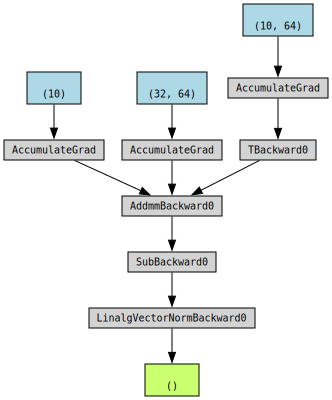

In [14]:
# computation graph
torchviz.make_dot(loss)

In [17]:
# common differentiable functions
torch.reshape
torch.transpose # identical mapping
torch.matmul # ...
torch.einsum # DL researchers' favorite

# nn.functional
nn.functional.linear # linear layer
nn.functional.conv2d # convolution
nn.functional.max_pool2d # pooling
# ......

<function torch.nn.functional.boolean_dispatch.<locals>.fn(*args, **kwargs)>

# Build a LeNet-5 (like) model
### PyTorch style data: Dataset -> Dataloader
1. torchvision dataset (very commonly used public datasets)
2. customized dataset (e.g. your own dataset)

#### Data augmentation:
resize, random crop, flip, normalize, ...

In [2]:
import torch
import torch.nn as nn
import torchviz
from torchsummary import summary

In [3]:
import torchvision

# transform
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    (0.1307,), (0.3081,))]) 

# transform is a function, excuted when indexing samples.


# check torchvision website
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Datasets collect data from your disk by default. You can consider customizing datasets to load it from RAM.

#### Dataloader:
batch size, shuffle, num_workers, pin_memory, ...

In [4]:
train_loaders = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loaders  = torch.utils.data.DataLoader(test_dataset,  batch_size=32, shuffle=False, pin_memory=True)

#### An introduction on Stochastic Gradient Descent, Batch GD, shuffling

....


shuffling: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=e84d12ea92b687e40960262a8fe3621d031d563c

##### Quick tips on batch size:
1. Larger batch size -> faster training (on the same number of data), larger memory usage
2. Smaller batch size -> flat minimum, better generalization (https://arxiv.org/pdf/1609.04836.pdf)

3. Krizhevsky (2014) says “Theory suggests that when multiplying the batch size by k, one should multiply the learning rate by √k to keep the variance in the gradient expectation
constant”, (https://arxiv.org/abs/1404.5997)
4. (https://arxiv.org/abs/1706.02677, image classification on ImageNet-1k) performance on 8k batch size matches on small batch size.
    They suggest "Linear Scaling Rule: When the minibatch size is multiplied by k, multiply the learning rate by k."
5. (https://arxiv.org/pdf/1804.00247.pdf, Neural Machine Translation on WMT-14) Translation performance is better on larger batch size under fixed training hours.


In [5]:
# dataloaders are iterators
image, label  = next(iter(train_loaders))
print(image.shape)

torch.Size([32, 1, 28, 28])


#### Define the model:
Common practice: inherit nn.Module and include a lot of nn.Module's as member variables. Define a forward function.

In [6]:
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.fc1 = nn.Linear(1250, 320)
        self.fc2 = nn.Linear(320, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out)

        out = out.view(x.shape[0], -1)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

#### GPU Scientific computing: CUDA
1. Introduced in CS121, but very simple in PyTorch (integrated in pip package since PyTorch 2.0, before which you need to install CUDA)
2. Usage: make every module and concerned tensors to "cuda"
3. Extend to multiple GPUs (on single/multiple machines) using Distributed Data Parallel.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = LeNet5().to(device)

# forward using model(x) model.forward(x)

#### Loss function (criterion) and optimizer, scheduler

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-7,)
# weight decay is equivalent to a L2 norm.

criterion = nn.CrossEntropyLoss()
# penalize the difference between the target one hot and the predicted label distribution.

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# change the learning rate during training.

### PyTorch training loop
epoch: one pass over the whole dataset

In [10]:
def valid(model, loader):
    total = 0
    correct = 0
    with torch.no_grad(): # save some memory by avoiding computation graph
        for image, label in loader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            pred_label = torch.argmax(pred, dim=1)
            total += image.shape[0]
            correct += (pred_label == label).sum().item()
    return correct / total

In [11]:
!pip install tqdm


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from tqdm import tqdm


print(valid(model, test_loaders))

epochs = 5
for epoch in range(epochs):
    for (image, label) in tqdm(train_loaders):

        image, label = image.to(device), label.to(device)

        # forward
        pred = model(image)

        loss = criterion(pred, label) # 别搞反了，否则算不出来。常看文档。
        
        optimizer.zero_grad() # set the grad to zero, otherwise gradients are accumulated across iterations.
        loss.backward() # compute gradient
        optimizer.step() # update parameters


    ### Evaluating (not essential for training)
    print(valid(model, test_loaders))

print(valid(model, test_loaders))


0.0577


100%|██████████| 1875/1875 [00:28<00:00, 64.83it/s]


0.9661


100%|██████████| 1875/1875 [00:31<00:00, 60.00it/s]


0.9792


100%|██████████| 1875/1875 [00:31<00:00, 59.63it/s]


0.9828


100%|██████████| 1875/1875 [00:31<00:00, 59.25it/s]


0.9844


100%|██████████| 1875/1875 [00:31<00:00, 59.78it/s]


0.989
0.989


#### Save and load model
(https://pytorch.org/tutorials/beginner/saving_loading_models.html)
My favorite way: using state_dict.

In [13]:
# save model
torch.save(model.state_dict(), 'lenet5.pt')

# load model
# first define the model

m = LeNet5()
m.load_state_dict(torch.load('lenet5.pt'))

<All keys matched successfully>

In [14]:
s = summary(m, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 28, 28]             520
         MaxPool2d-2           [-1, 20, 14, 14]               0
            Conv2d-3           [-1, 50, 10, 10]          25,050
         MaxPool2d-4             [-1, 50, 5, 5]               0
            Linear-5                  [-1, 320]         400,320
            Linear-6                   [-1, 10]           3,210
Total params: 429,100
Trainable params: 429,100
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 1.64
Estimated Total Size (MB): 1.84
----------------------------------------------------------------


#### A quick look at learning rate scheduler
1. multi-step scheduler: manually set milestones
2. Linear LR scheduler: linearly decrease the learning rate
3. Cosine Annealing LR scheduler: cosine annealing of the learning rate (https://openaccess.thecvf.com/content_CVPR_2019/papers/He_Bag_of_Tricks_for_Image_Classification_with_Convolutional_Neural_Networks_CVPR_2019_paper.pdf)
4. Cyclic LR scheduler: cyclically change the learning rate (https://arxiv.org/abs/1506.01186)
5. +Linear warmup scheduler: linearly increase the learning rate from 0 to the initial learning rate (https://arxiv.org/abs/1706.02677): a must for moderm large models.

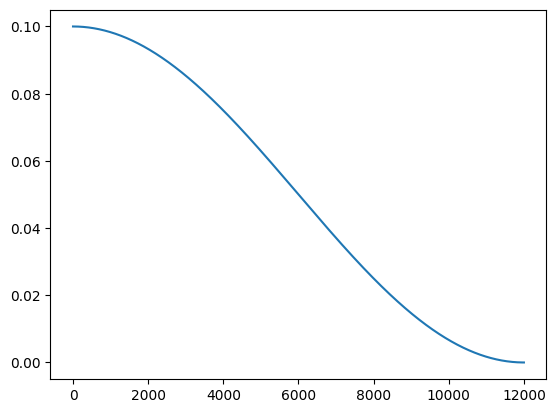

In [23]:
import matplotlib.pyplot as plt

optimizer = torch.optim.SGD(nn.Linear(1,1).parameters(), lr=0.1)

# you can consider update lr either each epoch or each iteration.
cosine_annealing_lr = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12000, eta_min=0, last_epoch=-1)

lrs = []
for i in range(12000):
    lrs.append(cosine_annealing_lr.get_last_lr())
    cosine_annealing_lr.step()

plt.plot(lrs)
plt.show()